In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import matplotlib.ticker as mtick

import datetime as dt

import scipy.stats as ss
import random
from scipy.stats import norm
from tqdm.auto import tqdm

# Задание 1

# Retention – один из самых важных показателей в компании. 
# Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [2]:
register = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zjubanova-36/shared/problem1-reg_data.csv', sep=';')

In [3]:
auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zjubanova-36/shared/problem1-auth_data.csv', sep=';')

Данные не очень разнообразные, исследуем на предмет ошибочного парсинга и пустых строк, а также повторяющихся значений

In [4]:
register.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
register.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
register.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
register[register.duplicated()]

,reg_ts,uid


In [8]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
auth[auth.duplicated()]

,auth_ts,uid


Объединим датафреймы в один для удобства 

In [12]:
reg_auth = register.merge(auth, on='uid', how='left')

Время в секундах не очень удобно для отслеживания даты, поэтому переведем его в привычный формат

In [13]:
reg_auth['reg_ts'] = pd.to_datetime(pd.to_datetime(reg_auth['reg_ts'], unit='s').dt.date)

In [14]:
reg_auth['auth_ts'] = pd.to_datetime(pd.to_datetime(reg_auth['auth_ts'], unit='s').dt.date)

Контроль того, что всё получилось корректно

In [15]:
reg_auth.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [16]:
def retention(reg_path, auth_path, mindate, maxdate):
    
    #Мерджим датафреймы и получаем один общий:
    reg_auth = reg_path.merge(auth_path, on='uid', how='left')
    
    #Переводим колонки из формата timestamp в формат datetime, то есть обычной даты:
    reg_auth['reg_ts'] = pd.to_datetime(pd.to_datetime(reg_auth['reg_ts'], unit='s').dt.date)
    reg_auth['auth_ts'] = pd.to_datetime(pd.to_datetime(reg_auth['auth_ts'], unit='s').dt.date)
   
    #Подсчитываем разницу между регистрацией и последней датой авторизации:
    reg_auth['delta'] = reg_auth['auth_ts'] - reg_auth['reg_ts']
    
    #Колонка delta получается в формате целых чисел, а нам нужен datetime.days, меняем: 
    reg_auth['delta'] = reg_auth['delta'].dt.days
    
    #Retention считается относительно какого-то временного отрезка времени, задаем его и считаем уникальные ID:
    reg_auth_dates = reg_auth \
                    .query("reg_ts <= @maxdate and reg_ts >= @mindate and auth_ts <= @maxdate") \
                    .groupby(['reg_ts', 'delta'], as_index = 0) \
                    .agg({'uid':'nunique'})
    
    #Ставим колонку с временем регистрации reg_ts в качестве индекса, чтобы далее было удобно группировать:
    reg_auth_dates.set_index(['reg_ts'], inplace=True)
    
    #Группируем и ищем максимальный uid для каждой отдельной даты:
    reg_auth_dates['uidmax'] = reg_auth_dates \
                                    .groupby('reg_ts') \
                                    .agg({'uid':'max'})
    
    #Считаем retention как отношение uid к максимальному uid:
    reg_auth_dates['retention'] = reg_auth_dates['uid'] / reg_auth_dates['uidmax']
    
    #Убираем индекс, чтобы произвести переформатирование таблицы для визуализации:
    reg_auth_dates.reset_index(inplace=True)
    
    #Создаем итоговую таблицу с retention:
    retention_table = reg_auth_dates.pivot(index='reg_ts', columns='delta', values='retention')
    
    #Задаем нужные настройки и создаем визуализацию для наглядности и удобства сравнения:
    sns.set()
    plt.style.use('ggplot')
    plt.figure(figsize=(30, 30))
    
    plt.title('Retention Rate', size=50)
    
    ax = sns.heatmap(data = retention_table, cmap = 'YlGn', annot=True, vmin=0, vmax=0.15, fmt='.1%')
    ax.set_yticklabels(retention_table.index.strftime('%Y-%m-%d'))
    
    plt.xlabel('Days since registration', size = 20)
    plt.ylabel('Date of registration', size = 20)
    plt.show()

In [17]:
start = input() #вводим год-месяц-день - дату, с которой начнется подсчет retention

2017-03-01


In [18]:
end = input() #вводим год-месяц-день - дату, на которой закончится подсчет retention

2017-03-30


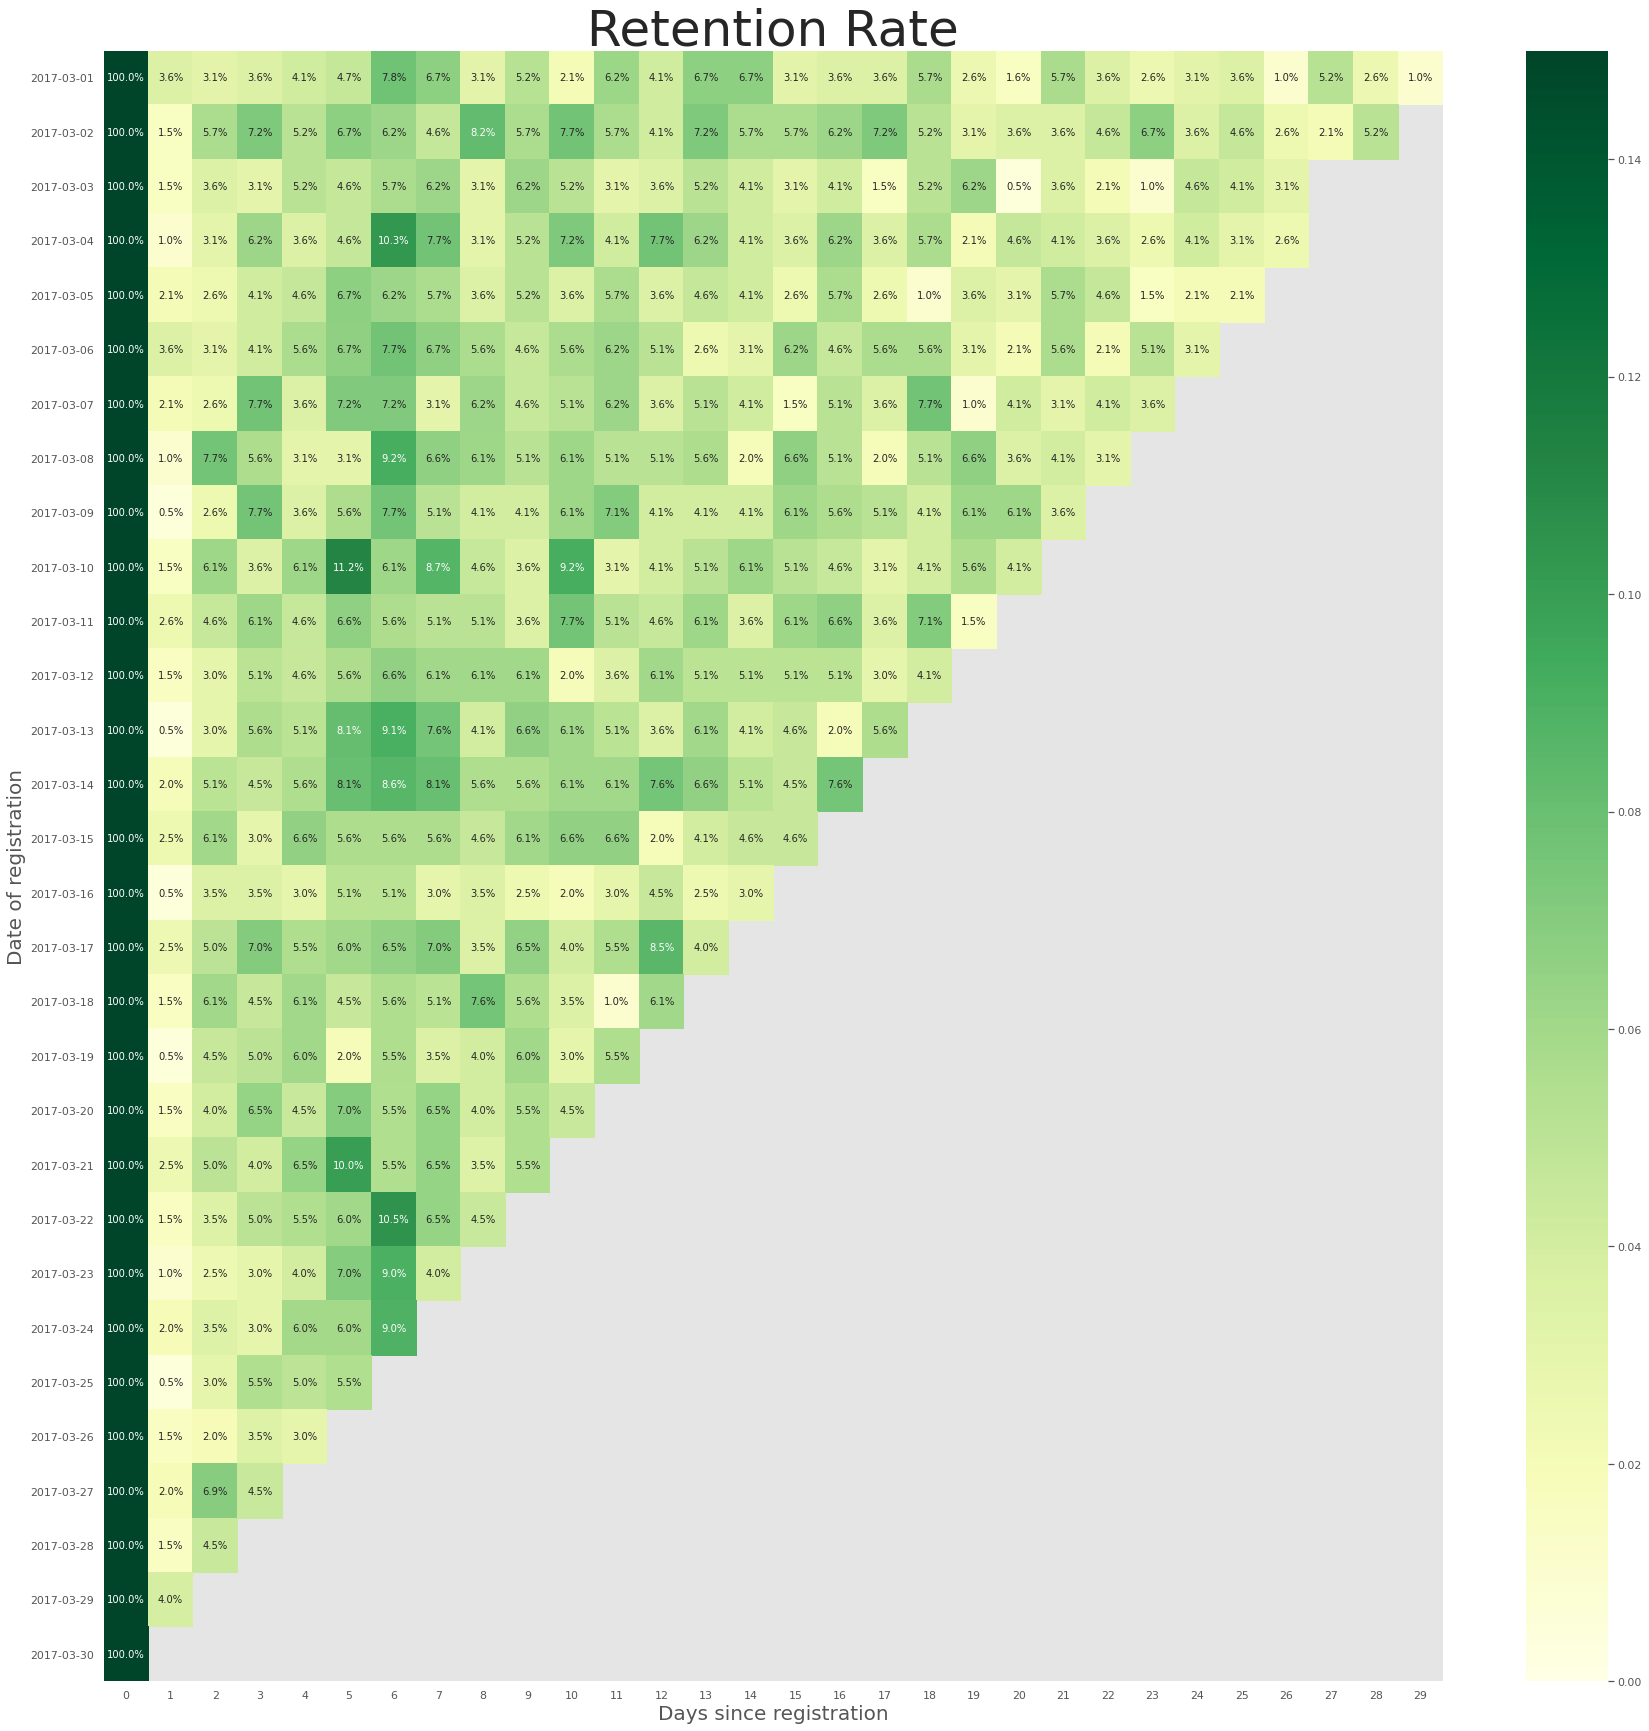

In [19]:
retention(register, auth, start, end)

# Задание 2
# Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

# Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [20]:
ab_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zjubanova-36/final_project/Проект_1_Задание_2.csv', sep = ';')

In [21]:
ab_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Изучаем данные аналогично первому заданию, но добавляем метод describe

In [22]:
ab_data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [23]:
ab_data.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [24]:
ab_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [25]:
ab_data[ab_data.duplicated()]

,user_id,revenue,testgroup


Посмотрим на распределение статистических показателей с разделением по тестовым группам

In [26]:
ab_data.groupby('testgroup').agg({'revenue':'describe'})

revenue                                                    
              count       mean         std  min  25%  50%  75%      max
testgroup                                                              
a          202103.0  25.413720  920.768137  0.0  0.0  0.0  0.0  37433.0
b          202667.0  26.751287  287.324162  0.0  0.0  0.0  0.0   4000.0

По таблице сверху видны непонятные сильные различия в столбцах std (стандартное отклонение) и max (максимальное значение). Есть предположение, что в данных могли ошибочно быть revenue = 0 в некоторых строках, попробуем убрать их вовсе и посмотреть на итог:

In [27]:
ab_data.query('revenue != 0').groupby('testgroup').agg({'revenue':'describe'})

revenue                                                            \
            count         mean          std     min     25%     50%     75%   
testgroup                                                                     
a          1928.0  2663.998444  9049.039763   200.0   257.0   311.0   361.0   
b          1805.0  3003.658172   572.619709  2000.0  2513.0  3022.0  3478.0   

                    
               max  
testgroup           
a          37433.0  
b           4000.0

Ситуация не изменилась, в некоторых моментах разница всё еще слишком большая. Посмотрим поближе на распределение дохода по каждой из групп:

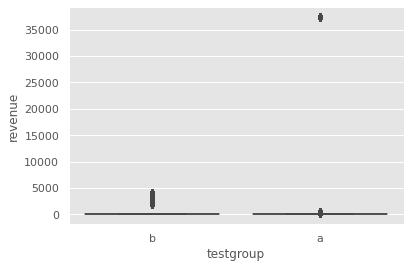

In [28]:
sns.boxplot(x = 'testgroup', y = 'revenue', data = ab_data)

Заметим выброс в районе отметки 35000

Посмотрим поближе на распределение выручки по группам

In [29]:
ab_data_a = ab_data.query('testgroup == "a"')

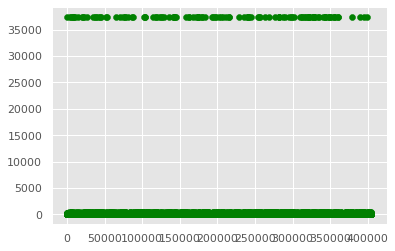

In [30]:
plt.scatter('user_id', 'revenue', color = 'green', data=ab_data_a)

In [31]:
ab_data_b = ab_data.query('testgroup == "b"')

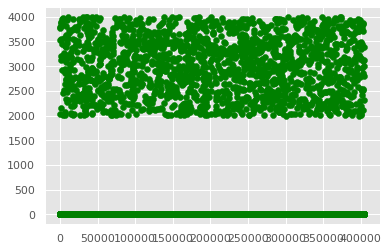

In [32]:
plt.scatter('user_id', 'revenue', color = 'green', data=ab_data_b)

По скаттерплотам замечаем, что есть значительные различия в распределении. В группе "а" массив приходится на отметку чуть выше 35000, в группе "b" большая часть сосредоточена между 2000 и 4000. Видно, что распределение ненормальное, однако стоит убедиться в этом с помощью теста Шапиро-Уилка:

In [33]:
ss.shapiro(ab_data[ab_data['testgroup'] == 'a']['revenue'].sample(500, random_state=15))

ShapiroResult(statistic=0.02232956886291504, pvalue=1.961817850054744e-44)

In [34]:
ss.shapiro(ab_data.query('testgroup == "a" & revenue != 0').revenue.sample(500, random_state=15))

ShapiroResult(statistic=0.29604822397232056, pvalue=9.412661914716229e-40)

In [35]:
ss.shapiro(ab_data.query('testgroup == "a" & revenue != 0 & revenue < 35000').revenue.sample(1000, random_state=15))

ShapiroResult(statistic=0.9510893821716309, pvalue=1.0175942808402844e-17)

In [36]:
ss.shapiro(ab_data[ab_data['testgroup'] == 'b']['revenue'].sample(500, random_state=15))

ShapiroResult(statistic=0.09335076808929443, pvalue=2.5223372357846707e-43)

In [37]:
ss.normaltest(ab_data.query('testgroup == "b" & revenue != 0').revenue.sample(1000, random_state=15))

NormaltestResult(statistic=516.7051180468438, pvalue=6.29374627045396e-113)

Таким образом, мы видим, что при разных выборках распределение действительно ненормальное, так как pvalue > 0.05

 Хочется поближе посмотреть на пользователей группы "а", оказавшихся выше отметки в 35000.

In [38]:
ab_data.query('revenue > 35000').user_id.count()

123

Видим, что всего 123 таких пользователя. Посмотрим на долю дохода, которую они принесли:

In [39]:
percent_a = round((ab_data.query('revenue > 35000 and testgroup == "a"').agg({'revenue':'sum'}))/(ab_data.query('testgroup == "a"').agg({'revenue':'sum'})) * 100, 2)
percent_a

revenue    89.37
dtype: float64

Найдем общий доход группы "а", чтобы потом посчитать доход с этих загадочных 123 пользователей в абсолютных числах:

In [40]:
revenue_a = ab_data.query('testgroup == "a"').agg({'revenue':'sum'})
revenue_a

revenue    5136189
dtype: int64

In [41]:
round((percent_a/100) * revenue_a)

revenue    4590212.0
dtype: float64

Видим, что это нам ни о чем не говорит из-за недостатка информации по группе "а" и конкретным 123 пользователям, поэтому стоит продолжить исследование. Для подсчета общих метрик посчитаем общий доход по группе "b":

In [42]:
revenue_b = ab_data.query('testgroup == "b"').agg({'revenue':'sum'})
revenue_b

revenue    5421603
dtype: int64

Так как в условии дана разница по ARPU, начнем с его подсчета:

In [43]:
arpu_a = ab_data.query('testgroup == "a"')['revenue'].sum() / ab_data.query('testgroup == "a"')['user_id'].nunique()
arpu_a.round(2)

25.41

In [44]:
arpu_b = ab_data.query('testgroup == "b"')['revenue'].sum() / ab_data.query('testgroup == "b"')['user_id'].nunique()
arpu_b.round(2)

26.75

In [45]:
abs((arpu_a - arpu_b) / arpu_a * 100)

5.263168360069894

In [46]:
abs((arpu_b - arpu_a) / arpu_b * 100)

5.00000944496214

Получаем именно те 5%, которые даны в условии и выясняем, что группа "a" - контрольная, группа "b" - тестовая. Теперь посчитаем ARPPU — Average revenue per paying user — и так же, как и с ARPU, посчитаем процентную разницу:

In [47]:
arppu_a = ab_data.query('testgroup == "a"')['revenue'].sum() / ab_data.query('testgroup == "a" and revenue != 0')['user_id'].nunique()
arppu_a

2663.9984439834025

In [48]:
arppu_b = ab_data.query('testgroup == "b"')['revenue'].sum() / ab_data.query('testgroup == "b" and revenue != 0')['user_id'].nunique()
arppu_b

3003.6581717451522

In [49]:
abs((arppu_b - arppu_a) / arppu_b * 100).round(1)

11.3

Видим, что ARPPU контрольной группы меньше тестовой на 11.3%

Теперь мы знаем, что данные распределены ненормально, а также между ними есть определенные различия. Здесь кажется подходящим методом исследования — bootstrap, я возьму функцию из соответсвующего урока по курсу. Определимся с гипотезами: 

Н0 - нет различий между контрольной и тестовой группами

Н1 - есть статистически значимые различия

In [50]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Применим функцию к тем же четырем выборкам, с которыми работали до:

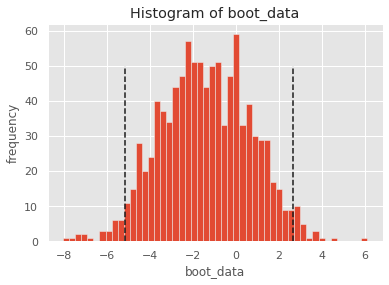

{'boot_data': [-3.4056999906250156,
  -1.1522250785771735,
  -1.1500638979212205,
  -3.0023486803475654,
  -1.7475415336487934,
  -3.440382499370889,
  -3.9520000789472385,
  -1.8602831245343348,
  -5.39152896130105,
  -2.298933718859015,
  -1.1872677840990393,
  -2.2119733355701716,
  -0.3270043963743481,
  2.7858210759521778,
  -1.003518086318937,
  2.6765334267542324,
  -0.1161067169297419,
  -3.708359032304223,
  -4.592276986386535,
  -1.582605949661267,
  -0.063078843620323,
  -1.2379913848825908,
  -4.796636847636764,
  -4.644046638081187,
  1.2279502829765083,
  -3.422269042320654,
  -3.7395431915408035,
  0.004746702719238949,
  -1.769123734993857,
  -0.1381922069207123,
  -0.4959169475050206,
  -2.431397316780729,
  -2.8056121618221024,
  1.974949054360108,
  -2.254871291330113,
  -2.408063473579813,
  1.3805158215200304,
  -2.6099562336246156,
  -2.400168749722451,
  -2.26917060991676,
  -1.0789275017639774,
  -4.600798353950076,
  -1.4061193978299378,
  2.547395481257432,
  

In [51]:
get_bootstrap(ab_data.query('testgroup == "a"')['revenue'], ab_data.query('testgroup == "b"')['revenue'])

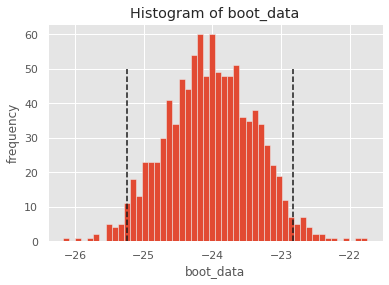

{'boot_data': [-24.508361005985186,
  -23.955281323550455,
  -24.638880528157028,
  -24.309818569377352,
  -24.543127396172046,
  -23.039498290298866,
  -23.14827278244608,
  -24.624452920307697,
  -24.607967750053042,
  -25.12020703913316,
  -24.246655844316045,
  -24.35861289701826,
  -23.985266471601197,
  -24.388257585102657,
  -23.563239205198677,
  -23.954570798403292,
  -24.67297586681601,
  -24.547691533402084,
  -24.17086649528537,
  -23.966763212560505,
  -23.99780427992717,
  -24.14049647944658,
  -23.564428347979693,
  -23.625898641614075,
  -23.18896514972837,
  -24.454084779465823,
  -23.20066907784691,
  -24.594531916888293,
  -25.18285167294133,
  -24.367499395560205,
  -24.645142031016395,
  -24.312492907084035,
  -24.329427089758077,
  -23.854894975501686,
  -24.904449170313864,
  -24.038916054414383,
  -23.47181336872801,
  -24.89026827258508,
  -25.26129068866663,
  -23.295011027942387,
  -23.92077151188896,
  -23.9580296742933,
  -24.795936190894423,
  -23.08684196

In [52]:
get_bootstrap(ab_data.query('testgroup == "a" and revenue < 35000')['revenue'], ab_data.query('testgroup == "b"')['revenue'])

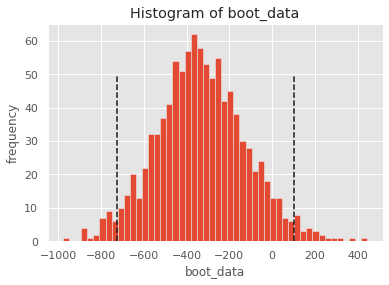

{'boot_data': [-264.3936721991701,
  -148.2759336099585,
  -648.3039419087137,
  2.429979253112033,
  -335.6094398340249,
  -321.31327800829877,
  -319.45435684647305,
  -401.9631742738589,
  -332.07002074688796,
  -554.7707468879668,
  -388.0311203319502,
  -377.84232365145226,
  -327.198132780083,
  -436.6317427385892,
  -556.5342323651453,
  -399.36203319502073,
  -139.68153526970954,
  -250.09336099585062,
  -408.39159751037346,
  -384.58402489626553,
  -447.3682572614108,
  -366.1633817427386,
  -387.82572614107886,
  -480.99896265560164,
  -365.8386929460581,
  88.68153526970954,
  -642.6908713692947,
  -264.2028008298755,
  -122.28526970954357,
  -865.688796680498,
  -316.56690871369295,
  -350.03890041493776,
  -67.04408713692946,
  -58.30653526970954,
  -573.9968879668049,
  -781.6369294605809,
  -374.3298755186722,
  -124.89107883817428,
  -311.59128630705396,
  -321.1913900414938,
  -435.82883817427387,
  -373.1509336099585,
  -206.5171161825726,
  -460.87033195020746,
  -42

In [53]:
get_bootstrap(ab_data.query('testgroup == "a" and revenue != 0')['revenue'], ab_data.query('testgroup == "b" and revenue != 0')['revenue'])

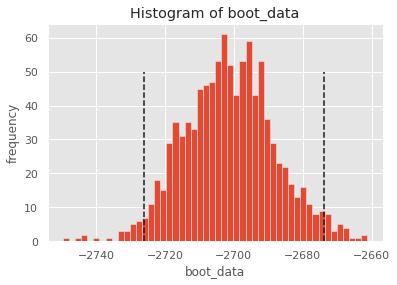

{'boot_data': [-2716.454293628809,
  -2707.9518005540167,
  -2710.6138504155124,
  -2693.932409972299,
  -2711.749030470914,
  -2706.714681440443,
  -2720.197783933518,
  -2694.9185595567865,
  -2720.3218836565097,
  -2673.6626038781164,
  -2715.7368421052633,
  -2704.5750692520774,
  -2691.9894736842107,
  -2683.3673130193906,
  -2698.6393351800552,
  -2697.7163434903046,
  -2684.603324099723,
  -2707.306371191136,
  -2706.501385041551,
  -2695.806648199446,
  -2690.4576177285317,
  -2718.899168975069,
  -2693.151246537396,
  -2715.8770083102495,
  -2718.0232686980607,
  -2700.692520775623,
  -2724.456509695291,
  -2701.248753462604,
  -2692.8626038781163,
  -2674.9617728531857,
  -2699.1335180055403,
  -2680.286426592798,
  -2722.8204986149585,
  -2704.664265927978,
  -2696.2991689750693,
  -2711.7091412742384,
  -2704.0481994459833,
  -2686.321329639889,
  -2679.6066481994458,
  -2682.029916897507,
  -2691.7473684210527,
  -2686.66648199446,
  -2702.1434903047093,
  -2727.0919667590

In [54]:
get_bootstrap(ab_data.query('testgroup == "a" and revenue > 0 and revenue < 35000')['revenue'], ab_data.query('testgroup == "b" and revenue > 0')['revenue'])

Из этих бутстрэпов 2-й и 4-й были построены без учета 123 пользователей (выброс). Теперь можно обоснованно сказать, что различия статистически значимы, так как значение pvalue < 0.05

На данный момент сделано достаточно показательных исследований и промежуточных выводов, так что можно давать итоговый ответ.

Препятствием для более глубокого исследования стал недостаток информации, а именно:
- неизвестно, что за акции проводились (какая-то конкретика)
- нет информации о том, на какие именно метрики и показатели хотели повлиять

Кроме того, так и не стало понятно, откуда берутся загадочные 123 пользователя в контрольной группе. Возможно, была допущена какая-то ошибка в ходе проведения А/Б теста, или это выброс, или попались более "элитные" пользователи, а может здесь имеет место быть другая природа. Эти 123 человека принесли 89% от общего дохода по группе, что кажется странным. В любом случае, для продолжения исследования без учета этих пользователей нет причин и оснований. Однако если всё же посмотреть на данные без этого выброса, то видно, что метрики в тестовой группе явно выше, чем в контрольной. Делаем вывод, что акцию потенциально можно распространять на всех пользователей. Но лучше предварительно убедиться в точности А/Б теста, проверить, что данные были собраны без ошибок.

# Задание 3
# В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

# Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

На мой взгляд, успех или неудачу можно отслеживать с помощью следующих метрик:

1. Количество игроков в каждом событии. Это позволит оценить популярность тематического события, качество маркетинговых кампаний (если они есть) и привлекательность событий на взгляд пользователей.
2. Среднее время, затраченное на прохождения каждого уровня: позволяет оценить сложность уровней относительно других, а также уровень игроков (опытные / средние / новички).
3. Количество уровней, пройденных до конца. Это показывает, насколько сложными были уровни относительно других, а также насколько пользователи были заинтересованы в прохождении уровней до конца (могло стать скучно в середине игры, например).
4. Количество потраченных монет и бонусов. Позволяет оценить, насколько пользователи были заинтересованы в получении наград и насколько они готовы тратить время на это. 
5. Количество полученных уникальных предметов. Эта метрика показывает, насколько сильно награды мотивировали игроков.

Теперь посмотрим на ситуацию, если при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Метрики для оценки результатов немного изменятся таким образом:

1. Количество попыток прохождения уровня. Позволяет оценить сложность уровней относительно других и степень готовности игроков тратить время на повтор прохождения.
2. Среднее время между попытками прохождения уровня. Позволит понять, насколько быстро игроки возвращаются к уровню после неудачи. 
3. Количество откатов назад. Покажет, насколько сложной была механика события и насколько игроки были подготовлены к такому формату.
4. Количество потраченных монет после неудачной попытки. Покажет, насколько игроки готовы тратить временные и материальные ресурсы на повтор прохождения уровней. 
5. Количество полученных уникальных предметов после неудачных попыток. Это позволит оценить, насколько важны награды для игроков после неудачи и насколько пользователи мотивированные.

Набор метрик может быть скорректирован по ходу проведения события. 